# 准备

In [1]:
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Vanishing/Exploding Gradients Problems

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

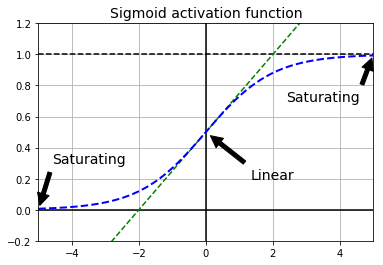

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

plt.plot(z, logit(z), 'b--', linewidth=2)

props = dict(facecolor='black', shrink=0.1)

plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), 
             arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), 
             arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), 
             arrowprops=props, fontsize=14, ha='center')

plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

## Xavier和 He 初始化

In [4]:
import tensorflow as tf
reset_graph()

In [5]:
n_inputs = 28 * 28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                         kernel_initializer=he_init, name="hidden1")

## 不饱和激活函数

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

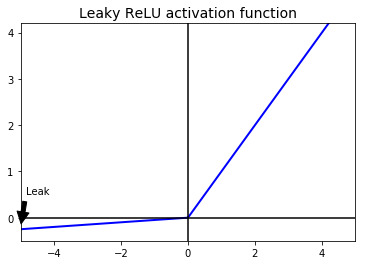

In [8]:
plt.plot(z, leaky_relu(z,0.05), 'b-', linewidth=2)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')

plt.annotate('Leak', xytext=(-4.5, 0.5), xy=(-5, -0.2), arrowprops=props, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

* 使用Leaky ReLU训练MNIST

In [11]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with  tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accurancy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

* 加载数据

In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accurancy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accurancy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accurancy:", acc_valid)
    save_path = saver.save(sess, "dnn/leaky_relu_model_final.ckpt")
file_write = tf.summary.FileWriter("dnn/leaky_relu", tf.get_default_graph())

0 Batch accuracy: 0.86 Validation accurancy: 0.9044
5 Batch accuracy: 0.94 Validation accurancy: 0.9494
10 Batch accuracy: 0.92 Validation accurancy: 0.9656
15 Batch accuracy: 0.94 Validation accurancy: 0.971
20 Batch accuracy: 1.0 Validation accurancy: 0.9762
25 Batch accuracy: 1.0 Validation accurancy: 0.9772
30 Batch accuracy: 0.98 Validation accurancy: 0.9782
35 Batch accuracy: 1.0 Validation accurancy: 0.9788


### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z)-1), z)

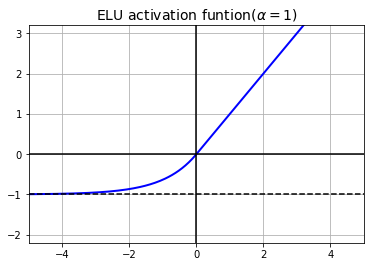

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.plot([-5, 5], [-1, -1], "k--")
plt.title(r"ELU activation funtion($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.grid(True)
plt.show()

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

## 批量标准化(Batch Normalization)

In [25]:
reset_graph()

import tensorflow as tf
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name="training")

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)


In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name="training")

In [27]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                             training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

In [30]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(
        tf.layers.batch_normalization,
        training=training,
        momentum=batch_norm_momentum
    )
    
    my_dense_layer = partial(
        tf.layers.dense,
        kernel_initializer=he_init
    )
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [31]:
n_epochs = 20
batch_size = 200

In [32]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], 
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "dnn/elu_model_final.ckpt")
    file_writer = tf.summary.FileWriter("dnn/elu", tf.get_default_graph())

0 Validation accuracy: 0.8952
1 Validation accuracy: 0.9202
2 Validation accuracy: 0.9318
3 Validation accuracy: 0.9422
4 Validation accuracy: 0.9468
5 Validation accuracy: 0.954
6 Validation accuracy: 0.9568
7 Validation accuracy: 0.96
8 Validation accuracy: 0.962
9 Validation accuracy: 0.9638
10 Validation accuracy: 0.9662
11 Validation accuracy: 0.9682
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9696
14 Validation accuracy: 0.9706
15 Validation accuracy: 0.9704
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9726
18 Validation accuracy: 0.9738
19 Validation accuracy: 0.9742


In [33]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [34]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

## 梯度裁剪

In [35]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10
 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [36]:
learning_rate = 0.01

In [37]:
threhold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threhold, threhold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [38]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [39]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [40]:
n_epochs = 20
batch_size = 200

In [43]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "dnn/clip_model_final.ckpt")
filewriter = tf.summary.FileWriter("dnn/clip", tf.get_default_graph())

0 Validation accuracy: 0.2906
1 Validation accuracy: 0.795
2 Validation accuracy: 0.8836
3 Validation accuracy: 0.9068
4 Validation accuracy: 0.9136
5 Validation accuracy: 0.9232
6 Validation accuracy: 0.93
7 Validation accuracy: 0.9342
8 Validation accuracy: 0.9384
9 Validation accuracy: 0.944
10 Validation accuracy: 0.9454
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9516
13 Validation accuracy: 0.9532
14 Validation accuracy: 0.9542
15 Validation accuracy: 0.9562
16 Validation accuracy: 0.9572
17 Validation accuracy: 0.9596
18 Validation accuracy: 0.9588
19 Validation accuracy: 0.9616


# 重利用之前训练的层

## 重利用TensorFlow模型

In [59]:
reset_graph()
saver = tf.train.import_meta_graph("dnn/clip_model_final.ckpt.meta")

In [60]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [61]:
#选择需要的
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [62]:
# 将重要的操作放在单独的集合中
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

In [63]:
# 或许这些操作
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

In [64]:
with tf.Session() as sess:
    saver.restore(sess, "dnn/clip_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "dnn/my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from dnn/clip_model_final.ckpt
0 Validation accuracy: 0.9626
1 Validation accuracy: 0.963
2 Validation accuracy: 0.9632
3 Validation accuracy: 0.9658
4 Validation accuracy: 0.965
5 Validation accuracy: 0.9628
6 Validation accuracy: 0.966
7 Validation accuracy: 0.9678
8 Validation accuracy: 0.9672
9 Validation accuracy: 0.9678
10 Validation accuracy: 0.97
11 Validation accuracy: 0.97
12 Validation accuracy: 0.966
13 Validation accuracy: 0.9706
14 Validation accuracy: 0.972
15 Validation accuracy: 0.9708
16 Validation accuracy: 0.9724
17 Validation accuracy: 0.9706
18 Validation accuracy: 0.972
19 Validation accuracy: 0.9684


In [65]:
# 重利用低层
reset_graph()
n_hidden4 = 20
n_outputs = 10

saver = tf.train.import_meta_graph("dnn/clip_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, 
                              activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="losss")
    
with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [66]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "dnn/clip_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = new_saver.save(sess, "dnn/my_new_low_layer_model_final.ckpt")

INFO:tensorflow:Restoring parameters from dnn/clip_model_final.ckpt
0 Validation accuracy: 0.9172
1 Validation accuracy: 0.9394
2 Validation accuracy: 0.9464
3 Validation accuracy: 0.95
4 Validation accuracy: 0.955
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9566
7 Validation accuracy: 0.9598
8 Validation accuracy: 0.9608
9 Validation accuracy: 0.9608
10 Validation accuracy: 0.9628
11 Validation accuracy: 0.9622
12 Validation accuracy: 0.9646
13 Validation accuracy: 0.9648
14 Validation accuracy: 0.9654
15 Validation accuracy: 0.9668
16 Validation accuracy: 0.9676
17 Validation accuracy: 0.9662
18 Validation accuracy: 0.9684
19 Validation accuracy: 0.968


## 冻结低层

In [69]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

init  = tf.global_variables_initializer()
new_saver = tf.train.Saver()


reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "dnn/clip_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = new_saver.save(sess, "dnn/my_new_freeze_low_layer_model_final.ckpt")

INFO:tensorflow:Restoring parameters from dnn/clip_model_final.ckpt
0 Validation accuracy: 0.893
1 Validation accuracy: 0.9234
2 Validation accuracy: 0.9358
3 Validation accuracy: 0.941
4 Validation accuracy: 0.947
5 Validation accuracy: 0.9484
6 Validation accuracy: 0.95
7 Validation accuracy: 0.954
8 Validation accuracy: 0.9542
9 Validation accuracy: 0.954
10 Validation accuracy: 0.955
11 Validation accuracy: 0.9548
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.957
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.958
18 Validation accuracy: 0.9586
19 Validation accuracy: 0.9582


## 缓冲冻结的层

In [86]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [92]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "dnn/clip_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    save_path = saver.save(sess, "dnn/my_new_cache_freeze_low_layer_model_final.ckpt")      

INFO:tensorflow:Restoring parameters from dnn/clip_model_final.ckpt
0 Validation accuracy: 0.9006
1 Validation accuracy: 0.9346
2 Validation accuracy: 0.9444
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.952
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.9532
8 Validation accuracy: 0.9546
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.955
11 Validation accuracy: 0.9554
12 Validation accuracy: 0.9558
13 Validation accuracy: 0.9572
14 Validation accuracy: 0.957
15 Validation accuracy: 0.9572
16 Validation accuracy: 0.9568
17 Validation accuracy: 0.9592
18 Validation accuracy: 0.958
19 Validation accuracy: 0.9598


# 更快的优化器

## Momentum optimization

In [93]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

## Nesterov Accelerated Gradient

In [94]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

In [95]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

In [97]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9,
                                     decay=0.9, epsilon=1e-10)

## Adam Optimization

In [98]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

In [99]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                              decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 50
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
    
    save_path = saver.save(sess, "dnn/learning_rate_scheduling_model_final.ckpt")

0 Validation accuracy: 0.9574
1 Validation accuracy: 0.9716
2 Validation accuracy: 0.973
3 Validation accuracy: 0.9798
4 Validation accuracy: 0.9816
